In [2]:
import skopt
res=skopt.load('script-test/2021-12-29-001131-dump.pkl')


(<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>,
 array([[<AxesSubplot:xlabel='maximumFunctionForCallInlineCandidateBytecodeCost', ylabel='Partial dependence'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='maximumOptimizationCandidateBytecodeCost'>,
         <AxesSubplot:xlabel='maximumOptimizationCandidateBytecodeCost', ylabel='Partial dependence'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='maximumFunctionForClosureCallInlineCandidateBytecodeCost'>,
         <AxesSubplot:>,
         <AxesSubplot:xlabel='maximumFunctionForClosureCallInlineCandidateBytecodeCost', ylabel='Partial dependence'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='maximumInliningCallerBytecodeCost'>,
         <AxesSubplot:>, <AxesSubplot:>,
         <AxesSub

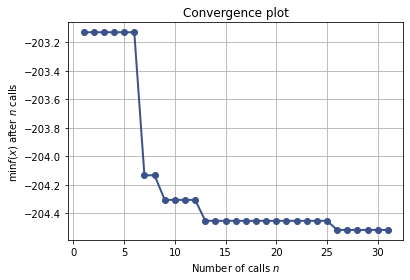

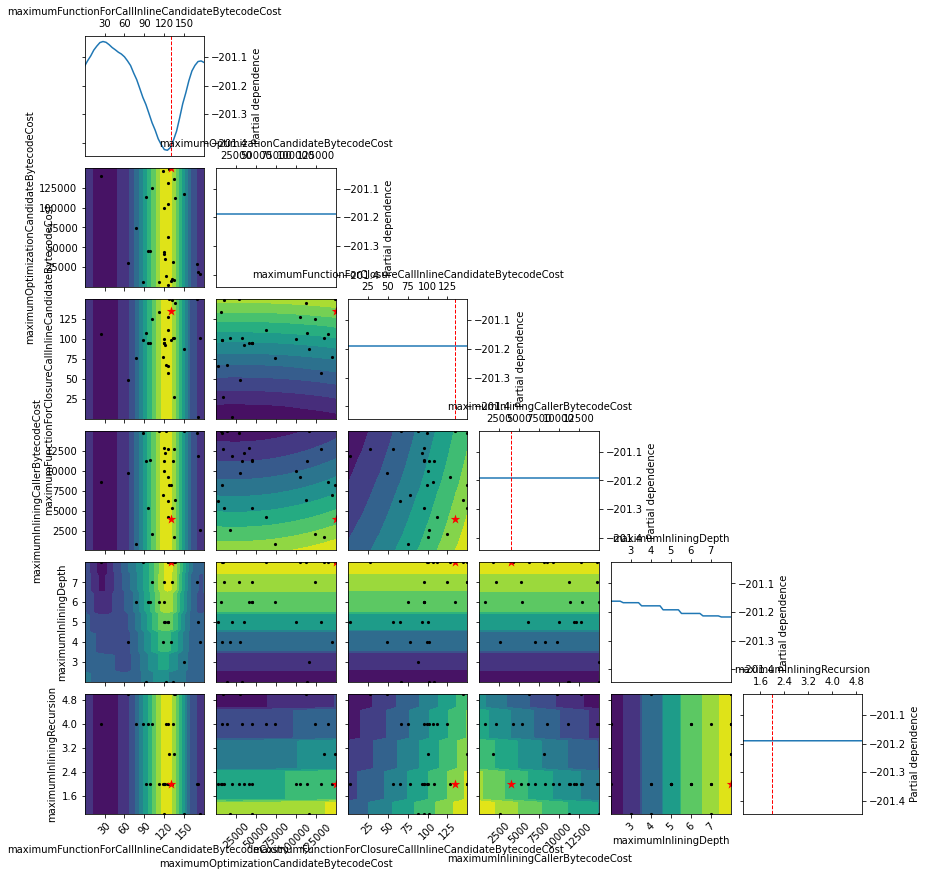

In [3]:
from collections import namedtuple
Parameter = namedtuple('Parameter', ('name', 'range', 'default'))
parameters = (Parameter('maximumFunctionForCallInlineCandidateBytecodeCost', (0, 180), 120),
              Parameter('maximumOptimizationCandidateBytecodeCost', (0, 150000), 100000),
              Parameter('maximumFunctionForClosureCallInlineCandidateBytecodeCost', (0, 150), 100 ),
              Parameter('maximumInliningCallerBytecodeCost', (0, 15000), 10000),
              Parameter('maximumInliningDepth', (2,8), 5),
              Parameter('maximumInliningRecursion', (1,5), 2),
             )


from skopt import plots
plots.plot_convergence(res), plots.plot_objective(res, dimensions=[p.name for p in parameters])